In [1]:
import numpy as np
import pandas as pd
import os , glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing import image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , utils , datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


## Unzipping files

In [ ]:
!unzip '/kaggle/input/carvana-image-masking-challenge/train_hq.zip' -d './'
!unzip '/kaggle/input/carvana-image-masking-challenge/train_masks.zip' -d './'
!unzip '/kaggle/input/carvana-image-masking-challenge/train.zip' -d './'
!unzip '/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip' -d './'

## Dataset

In [3]:
pth = './train'
# os.listdir('./train_hq')
# len(os.listdir(pth))
data = pd.read_csv('train_masks.csv')
data

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...


(1280, 1918, 3)


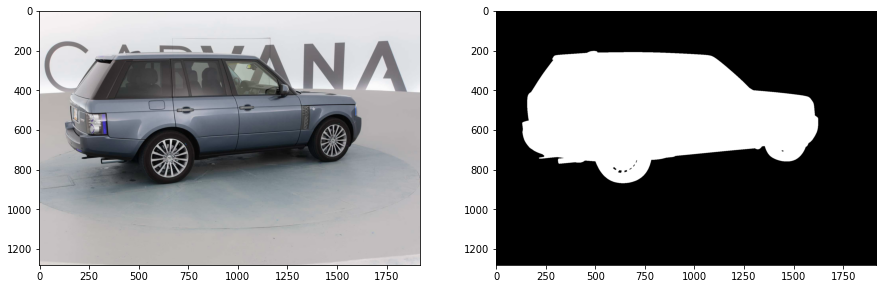

In [4]:
fig=plt.figure(figsize=(15, 15))
img=cv2.imread('./train/fff9b3a5373f_12.jpg')
mask=Image.open('./train_masks/fff9b3a5373f_12_mask.gif') #Image from PIL 
print(img.shape)
files=[img,mask]
for i in range(len(files)):
    plt.subplot(1, 2 , i+1)
    plt.imshow(files[i])

In [5]:
root_dir = './train'
images = pd.read_csv('./train_masks.csv')['img']
len(images) # contains all images
img_list = images

./train/00087a6bd4dc_03.jpg
./train/00087a6bd4dc_03.jpg
./train_masks/00087a6bd4dc_03_mask.gif


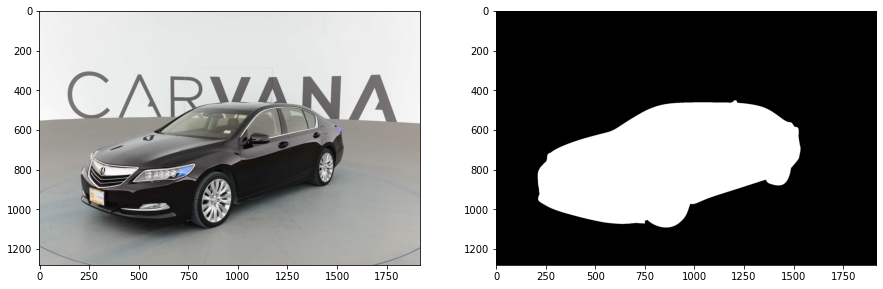

In [6]:
# testing some path and data
img_name = img_list[2]
img_path = root_dir + '/' + str(img_name)
img2 = os.path.join(root_dir,img_name)
print(img_path)
print(img2)

mask_name = img_name.split('.')[0] + '_mask.gif'
mask_path = root_dir + '_masks/' + str(mask_name)
print(mask_path)

img = cv2.imread(img_path)
# print(plt.imshow(img))

mask = plt.imread(mask_path) # for masks
# plt.imshow(mask)

fig=plt.figure(figsize=(15, 15))
files=[img,mask]
for i in range(len(files)):
    plt.subplot(1, 2 , i+1)
    plt.imshow(files[i])

In [7]:
#Custom Dataset Class
class CaravanDataset(Dataset) :
    
    def __init__(self,root_dir,img_list,transform_img=None,transform_m=None) :
        
        self.root_dir = root_dir
        self.image_list = img_list
        self.transform_img = transform_img
        self.transform_m = transform_m
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self,idx) :
        
        img_name = self.image_list[idx]
        img_path = self.root_dir +'/'+ str(img_name)
        
        mask_name = img_name.split('.')[0] + '_mask.gif'
        mask_path = self.root_dir +'_masks/'+ str(mask_name)
        
        img = cv2.imread(img_path)
        mask = Image.open(mask_path)    #Object of PIL 
        mask = image.img_to_array(mask)
        

        
        if self.transform_img :
            img = self.transform_img(image=img)['image']
            
        if self.transform_m :
            mask = self.transform_m(image=mask)['image']
        
        return img,mask

In [8]:
# Transforms

transform_img = A.Compose([
    A.Resize(600,600),
    A.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
    ToTensorV2()])

transform_mask = A.Compose([
    A.Resize(600,600),ToTensorV2()])

images = (pd.read_csv('./train_masks.csv')['img'])
dataset = CaravanDataset('./train',images,transform_img,transform_mask)

In [9]:
# testing dataset
i = 0
for x,y in dataset:
    if i == 5: break
    print(x.shape,y.shape)
    i+=1

torch.Size([3, 600, 600]) torch.Size([1, 600, 600])
torch.Size([3, 600, 600]) torch.Size([1, 600, 600])
torch.Size([3, 600, 600]) torch.Size([1, 600, 600])
torch.Size([3, 600, 600]) torch.Size([1, 600, 600])
torch.Size([3, 600, 600]) torch.Size([1, 600, 600])


In [10]:
# Split into Train and Validation Set
train_size = int(len(images)*0.8)
val_size = len(images)-train_size
print(train_size,val_size)

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size]) # We sample 10% of the images as a validation dataset

train_dataloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=4,
                                          shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(val_set,
                                          batch_size=4,
                                          shuffle=True)

4070 1018


In [11]:
# Testing TrainLoader
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([4, 3, 600, 600])

## Modified UNet Network

In [12]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [13]:
# import torch
# import torch.nn as nn  

# # print(torch.cuda.is_available())

# def double_conv(in_c,out_c):
#     conv = nn.Sequential(
#         nn.Conv2d(in_c, out_c,kernel_size = 3),
#         nn.ReLU(inplace=True),

#         nn.Conv2d(out_c, out_c,kernel_size = 3),
#         nn.ReLU(inplace=True)
#     )
#     return conv

# def crop_image(tensor,target):
#     target_size = target.size()[2]
#     tensor_size = tensor.size()[2]

#     diff = tensor_size - target_size
#     diff = diff // 2

#     return tensor[:,:,diff:tensor_size-diff,diff:tensor_size-diff]



# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()

#         self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.down_conv1 = double_conv(3,64)
#         self.down_conv2 = double_conv(64,128)
#         self.down_conv3 = double_conv(128,256)
#         self.down_conv4 = double_conv(256,512)
#         self.down_conv5 = double_conv(512,1024)

#         self.up_trans1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
#         self.up_conv1 = double_conv(1024,512)

#         self.up_trans2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
#         self.up_conv2 = double_conv(512,256)

#         self.up_trans3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
#         self.up_conv3= double_conv(256,128)

#         self.up_trans4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
#         self.up_conv4 = double_conv(128,64)

#         self.out = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)




#     def forward(self, image):
#         #encoder
#         x1 = self.down_conv1(image) #op
#         x2 = self.max_pool_2x2(x1)

#         x3 = self.down_conv2(x2) #op
#         x4 = self.max_pool_2x2(x3)

#         x5 = self.down_conv3(x4) #op
#         x6 = self.max_pool_2x2(x5)

#         x7 = self.down_conv4(x6) #op
#         x8 = self.max_pool_2x2(x7)

#         x9 = self.down_conv5(x8) #op

#         #decoder
#         x = self.up_trans1(x9)
#         y = crop_image(x7, x)
#         x =  self.up_conv1(torch.cat([x,y],1))

#         x = self.up_trans2(x)
#         y = crop_image(x5, x)
#         x =  self.up_conv2(torch.cat([x,y],1))

#         x = self.up_trans3(x)
#         y = crop_image(x3, x)
#         x =  self.up_conv3(torch.cat([x,y],1))

#         x = self.up_trans4(x)
#         y = crop_image(x1, x)
#         x =  self.up_conv4(torch.cat([x,y],1))

#         x = self.out(x)


#         print(x1.size())
#         print(x3.size())
#         print(x5.size())
#         print(x7.size())
#         print(x9.size())

#         # print(x.size())
#         print(y.size())

#         print(x.size())
        
#         return x
#         # check x7 and x size. so either 1.crop 2.padding

#         # batch size, channel, height, width
# if __name__ == "__main__":
#     image = torch.rand((1,1,572,572))
#     model = UNet()
# #     print(model)
# #     print(model(image)

In [14]:
def dice_calc(gt,pred) :
    pred = torch.sigmoid(pred)
    pred = ((pred) >= .5).float()
    dice_score = (2 * (pred * gt).sum()) / ((pred + gt).sum() + 1e-8)
    
    return dice_score

In [15]:
# net = UNet()
# net.to(device=device)

# optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)

# criterion = nn.CrossEntropyLoss()

In [16]:
net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)

optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

if net.n_classes > 1:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCEWithLogitsLoss()

In [17]:
# Train
def train(epoch,epochs,tloader) :
    net.train()
    
    tloader.set_description(f'EPOCH {epoch}')
    epoch_loss = 0
    dice_score = 0
    num_correct = 0    
    
    for images , masks in tloader :
 
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)
        mask_pred = net(images)

        loss = criterion(mask_pred,masks)
        epoch_loss += loss.item()      
        loss.backward()
        optimizer.step()
    
        running_DS = dice_calc(masks,mask_pred)
        dice_score += running_DS
                
        tloader.set_postfix(loss=loss.item(),accuracy=(running_DS.item()))
    print(' Train Dice Score Epoch : ',dice_score/len(train_dataloader))
    
def validation(vloader) :
    net.eval()
    vloader.set_description('Validation')
    
    n_val = len(valid_dataloader)
    total = 0
    dice_score = 0
    num_correct = 0
    
    with torch.no_grad():
        for images ,masks in vloader :

            images = images.to(device)
            masks  = masks.to(device)
                
            mask_pred = net(images)
            
            loss = criterion(mask_pred,masks)
            
            running_DS = dice_calc(masks,mask_pred)
            dice_score += running_DS
            
            vloader.set_postfix(loss=loss.item(),accuracy=(running_DS.item()))
        
    print('Validation Dice Score Epoch : ',dice_score/len(valid_dataloader))

In [19]:
epochs = 3

for epoch in range(epochs) :
    print(epoch+1,'/',epochs)
    with tqdm(train_dataloader,unit='batch') as tloader : 
        train(epoch,epochs,tloader)
    
    with tqdm(valid_dataloader,unit='batch') as vloader:
        validation(vloader)

EPOCH 0:   0%|          | 0/1018 [00:00<?, ?batch/s]

1 / 3


Validation:   0%|          | 0/255 [00:00<?, ?batch/s]

 Train Dice Score Epoch :  tensor(0.9775, device='cuda:0')


EPOCH 1:   0%|          | 0/1018 [00:00<?, ?batch/s]

Validation Dice Score Epoch :  tensor(0.9854, device='cuda:0')
2 / 3


Validation:   0%|          | 0/255 [00:00<?, ?batch/s]

 Train Dice Score Epoch :  tensor(0.9885, device='cuda:0')


EPOCH 2:   0%|          | 0/1018 [00:00<?, ?batch/s]

Validation Dice Score Epoch :  tensor(0.9908, device='cuda:0')
3 / 3


Validation:   0%|          | 0/255 [00:00<?, ?batch/s]

 Train Dice Score Epoch :  tensor(0.9912, device='cuda:0')


Validation: 100%|██████████| 255/255 [01:55<00:00,  2.21batch/s, accuracy=0.993, loss=0.00584]

Validation Dice Score Epoch :  tensor(0.9925, device='cuda:0')


In [3]:
# import torch
# torch.save(net.state_dict(), "net_model.pt")

NameError: name 'net' is not defined

# Testing

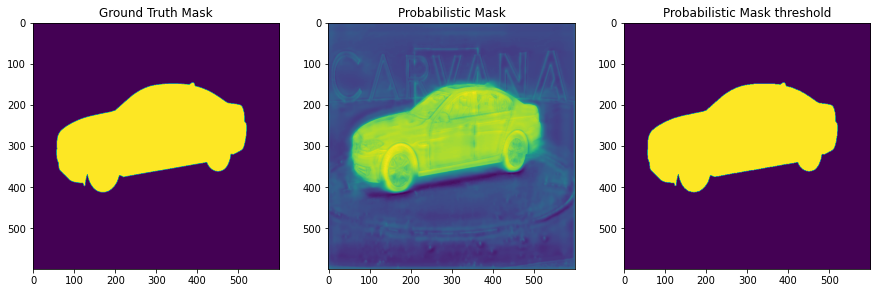

In [21]:
# Tests
with torch.no_grad():
    for images ,masks in valid_dataloader :
        images = images.to(device)
        masks  = masks.to(device)

        mask_pred = net(images)

        img = mask_pred.cpu().numpy()
        masks = masks.cpu().numpy()
        masks_2 = (masks > 0.5).astype(int)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 15))
        
        axes[0].imshow(masks[0][0])
        axes[0].set_title('Ground Truth Mask')
        
        axes[1].imshow(img[0][0])
        axes[1].set_title('Probabilistic Mask')
        
        axes[2].imshow(masks_2[0][0])
        axes[2].set_title('Probabilistic Mask threshold')
        break



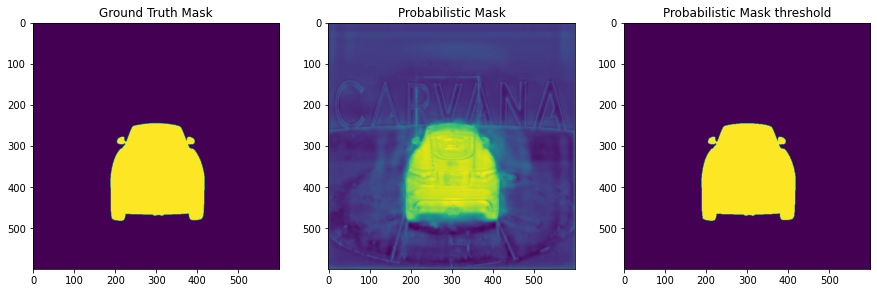

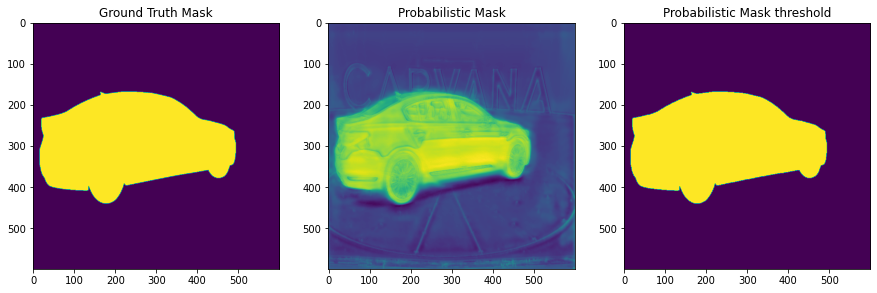

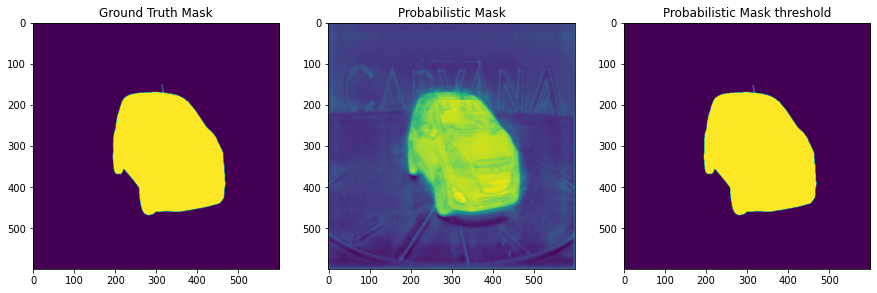

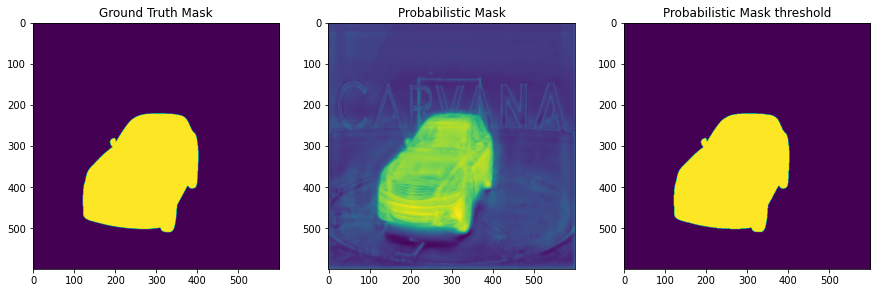

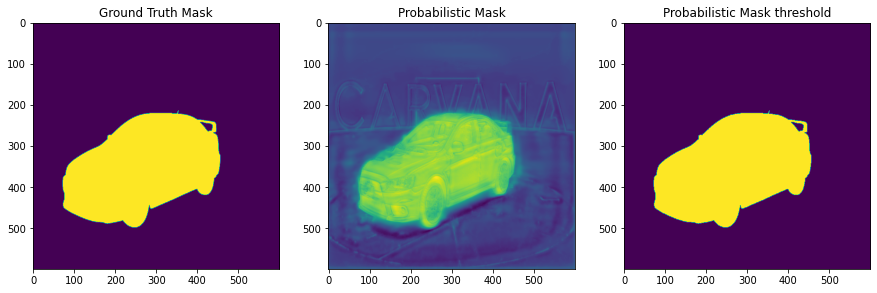

In [25]:
# Tests

for i in range(5):
    with torch.no_grad():
        for images ,masks in valid_dataloader :
            images = images.to(device)
            masks  = masks.to(device)

            mask_pred = net(images)

            img = mask_pred.cpu().numpy()
            masks = masks.cpu().numpy()
            masks_2 = (masks > 0.5).astype(int)

            fig, axes = plt.subplots(1, 3, figsize=(15, 15))

            axes[0].imshow(masks[0][0])
            axes[0].set_title('Ground Truth Mask')

            axes[1].imshow(img[0][0])
            axes[1].set_title('Probabilistic Mask')

            axes[2].imshow(masks_2[0][0])
            axes[2].set_title('Probabilistic Mask threshold')
            
            break

